In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('GroundTruth.csv')

/Users/bigyanbhandari/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,SchoolName,StateName,StateAbbr,SchoolID-NCESAssigned,CountyName,Locale,TotalStudents,FreeLunchEligible,AmericanIndian/AlaskaNative,AsianorAsian/PacificIslander,Hispanic,BlackorAfricanAmerican,White,Full-TimeEquivalent(FTE)Teachers
0,1 SCHOOL ...,New York,NY,3.616830e+11,NASSAU,4-Urban fringe of midsize city,334,–,†,†,†,†,†,30.9
1,14TH AVE ELEM SCH,Alabama,AL,1.017200e+10,WINSTON,6-Small town,570,0,0,0,0,0,0,29
2,1ST WARD EL,Wisconsin,WI,5.502550e+11,CHIPPEWA,4-Urban fringe of midsize city,196,33,1,5,1,†,189,11
3,21ST ST ELEM SCH,Alabama,AL,1.017200e+10,WINSTON,6-Small town,396,0,0,0,0,0,0,16
4,4-J ELEMENTARY SCHOOL,Wyoming,WY,5.601470e+11,CAMPBELL,6-Small town,44,†,†,†,†,†,†,†


In [4]:
texas_count = df['StateName'] == 'Texas'

In [5]:
texas_count.sum()

23625

There are 23625 schools from Texas in our dataframe. We will be using the values from these schools to extablish a baseline labeling for identifying schools as High poverty stricken, povery stricken and no poverty stricken to establish our classification criteria for poverty status of public schools.

In order to be able to do so, we will first see the distribution of the percentage of public school students reported to be eligible for free lunch by each school.

In [6]:
df['FreeLunchEligible'] = df['FreeLunchEligible'].apply( lambda x : int(x) if (str(x)).isdigit() else None)

In [7]:
df.shape

(335511, 14)

In [8]:
df['FreeLunchEligible'].isna().sum()

220973

In [9]:
df = df[df['FreeLunchEligible'].notna()]

In [10]:
df.shape

(114538, 14)

In [11]:
df['TotalStudents'] = df['TotalStudents'].apply( lambda x : int(x) if (str(x)).isdigit() else None)

In [12]:
df['TotalStudents'].isna().sum()

52

In [13]:
df = df[df['TotalStudents'].notna()]

In [14]:
df.shape

(114486, 14)

In [15]:
df = df.drop(df[df['TotalStudents'] == 0].index)

In [16]:
df.shape

(110876, 14)

In [17]:
df['proportion_free_lunch'] = df['FreeLunchEligible']/df['TotalStudents']

(0.0, 4000.0)

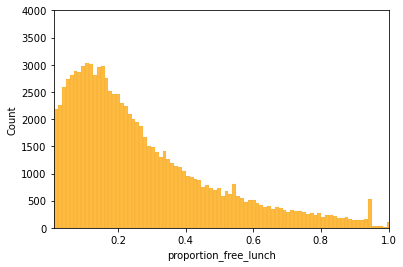

In [18]:
sns.histplot( data = df, x = 'proportion_free_lunch', color = 'orange',  common_norm = True)
plt.xlim(0.01,1)
plt.ylim(0,4000)

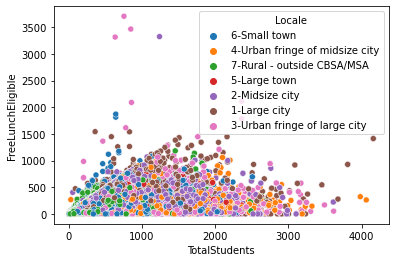

In [19]:
ax = sns.scatterplot(y = df['FreeLunchEligible'], x = df['TotalStudents'], hue = df['Locale'])

We notice that a large number of schools that reported the number of Free Lunch eligibile students have less than 20% students eligible for free lunch. The distribution is skewed towards left. There is no observable correlation between the total number of students and number of free lunch eligible students when we do not consider the locale of the school.

For the purposes of this feasibility study, we will focus on the State of Texas and establish Ground Truth Analysis to be able to categorize schools as strict poverty striken, high povery striken and no povery striken.

In [20]:
ind_texas = df['StateName']=='Texas'

In [21]:
ind_texas.sum()

0

Unfortunately, none of the Texas Schools reported freelunch eligibile student numbers for the timeperiod under consideration. As such, we will just go ahead and pick the whole dataframe as a basis for coming up with the criteria for classification of schools.

In [22]:
df['proportion_free_lunch'].describe()

count    110876.000000
mean          0.236138
std           0.231792
min           0.000000
25%           0.065574
50%           0.174419
75%           0.340764
max           9.925926
Name: proportion_free_lunch, dtype: float64

In [23]:
free_lunch_prop_more_than_one = df[df['proportion_free_lunch'] > 1].index  # to drop invalid data

In [24]:
df= df.drop(free_lunch_prop_more_than_one)

In [25]:
df['proportion_free_lunch'].describe()

count    110601.000000
mean          0.232972
std           0.218517
min           0.000000
25%           0.065336
50%           0.173913
75%           0.339450
max           1.000000
Name: proportion_free_lunch, dtype: float64

Census Bureau's poverty rates for the US for years 1987 through 1990 are: 13.5%, 13.1%, 13.1%, 13.5%. Ideally, if free lunch eligibility was tied to poerty status of a family a student, we would expect to see this correlation between proportion of free-lunch eligible students and poverty rate.

In [26]:
df['no_free_lunch_eligible'] = df['proportion_free_lunch'].apply( lambda x : 1 if x ==0 else 0)

In [27]:
df['no_free_lunch_eligible'].sum() / 110876

0.13073162812511274

13% of the schools had no student eligible for free-lunch program. We are assuming if a school reported 0, it means they found no-one eligible for the program and not that the data is missing. 



In [28]:
df['less_than_poverty_rate'] = df['proportion_free_lunch'].apply( lambda x : 1 if x < 0.135 else 0)
df['less_than_poverty_rate'].sum() / 110876

0.4105757783469822

Looks like 41% of school have population body that are doing better than US poverty rate if we believe general US poverty rate and free lunch eligibility are correlated. This number seems statistically significant and could be an indicative of a need to either redefine free lunch eligibility or an indicator that schools serve in mostly affluent neighborhoods.

In [29]:
df['FreeLunchEligible'].sum() / df['TotalStudents'].sum()

0.22609381547728882

Almost 23 % of student body was eligible for free-lunch, which is higher than poverty rates, but 41% of schools reported that the percent of free lunch eligible students in their school was less than national poverty rate. This signifies that schools that reported schools that had more poor students tend to be larger than schools that have less poor students.

(0.0, 1.0)

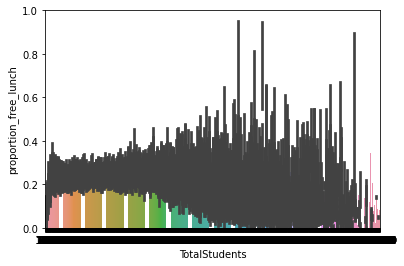

In [30]:
ax = sns.barplot(data = df, y = 'proportion_free_lunch', x = 'TotalStudents')
plt.ylim(0,1)

In [31]:
df['TotalStudents'].groupby(df['Locale']).describe()

,count,mean,std,min,25%,50%,75%,max
Locale,,,,,,,,
1-Large city,5863.0,639.921030,436.204624,1.0,380.0,545.0,763.5,4161.0
2-Midsize city,17701.0,592.843794,387.607422,1.0,352.0,504.0,718.0,3615.0
3-Urban fringe of large city,11418.0,619.060694,403.074932,2.0,365.0,525.0,746.0,3619.0
4-Urban fringe of midsize city,11843.0,639.243266,417.115683,1.0,365.0,553.0,808.0,4065.0
5-Large town,2767.0,514.728226,351.774806,8.0,305.5,430.0,611.0,2360.0
6-Small town,26093.0,470.894569,295.382218,1.0,277.0,424.0,615.0,2508.0
7-Rural - outside CBSA/MSA,34916.0,297.703603,254.013764,1.0,120.0,234.0,410.0,2703.0


In [32]:
df['proportion_free_lunch'].groupby(df['Locale']).describe()

,count,mean,std,min,25%,50%,75%,max
Locale,,,,,,,,
1-Large city,5863.0,0.432099,0.293044,0.0,0.179616,0.442231,0.660285,1.00000
2-Midsize city,17701.0,0.270377,0.231348,0.0,0.089431,0.215686,0.394584,1.00000
3-Urban fringe of large city,11418.0,0.153525,0.186963,0.0,0.022267,0.080303,0.209622,0.96587
4-Urban fringe of midsize city,11843.0,0.217760,0.204719,0.0,0.055655,0.166172,0.318318,1.00000
5-Large town,2767.0,0.212159,0.190199,0.0,0.077803,0.170686,0.296754,1.00000
6-Small town,26093.0,0.216950,0.200866,0.0,0.070423,0.162791,0.308364,1.00000
7-Rural - outside CBSA/MSA,34916.0,0.225335,0.203098,0.0,0.078125,0.179191,0.315132,1.00000


Large city area schools have the highest mean value for the percentage of students eligible for free lunch. Those schools also tend to be larger on average, with average student body count 640 being the highest - along with schools at the urban fringe of midsize city.



<AxesSubplot:title={'center':'proportion_free_lunch'}, xlabel='Locale'>

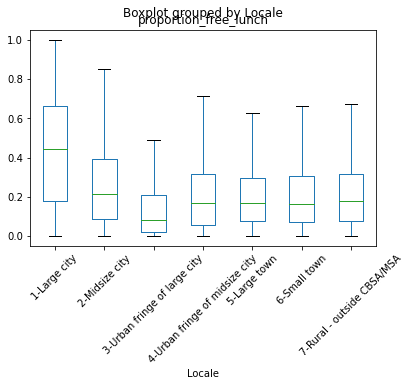

In [33]:
df.boxplot(by="Locale", column="proportion_free_lunch", rot = 45, showfliers = False, grid = False)

The observation made from the data table can be observed more clearly in the boxplot. Large city schools have the highest proportion of free lunch eligible students.

## Racial Makeup of schools

In [34]:
df['AmericanIndian/AlaskaNative'] = df['AmericanIndian/AlaskaNative'].apply( lambda x : int(x) if str(x).isdigit() else 0)
df['AsianorAsian/PacificIslander'] = df['AsianorAsian/PacificIslander'].apply( lambda x : int(x) if str(x).isdigit() else 0)
df['Hispanic'] = df['Hispanic'].apply( lambda x : int(x) if str(x).isdigit() else 0)
df['BlackorAfricanAmerican'] = df['BlackorAfricanAmerican'].apply( lambda x : int(x) if str(x).isdigit() else 0)
df['White'] = df['White'].apply( lambda x : int(x) if str(x).isdigit() else 0)

In [35]:
display(df[['AmericanIndian/AlaskaNative', 'AsianorAsian/PacificIslander', 'Hispanic', 'BlackorAfricanAmerican','White']].groupby(df['Locale']).describe().transpose())


Locale                              1-Large city  2-Midsize city  \
AmericanIndian/AlaskaNative  count   5863.000000    17701.000000   
                             mean       2.902439        2.638156   
                             std       11.549060        8.941718   
                             min        0.000000        0.000000   
                             25%        0.000000        0.000000   
                             50%        0.000000        0.000000   
                             75%        1.000000        2.000000   
                             max      322.000000      229.000000   
AsianorAsian/PacificIslander count   5863.000000    17701.000000   
                             mean      12.074194       14.571493   
                             std       34.958226       76.477415   
                             min        0.000000        0.000000   
                             25%        0.000000        0.000000   
                             50%        0.000000        1.000000   
                             75%        7.000000        8.000000   
                             max      569.000000     2347.000000   
Hispanic                     count   5863.000000    17701.000000   
                             mean      69.530957       16.149031   
                             std      222.670639       46.437229   
                             min        0.000000        0.000000   
                             25%        0.000000        0.000000   
                             50%        1.000000        1.000000   
                             75%       19.000000       11.000000   
                             max     3039.000000     1217.000000   
BlackorAfricanAmerican       count   5863.000000    17701.000000   
                             mean     204.714822       80.095814   
                             std      302.860937      152.024444   
                             min        0.000000        0.000000   
                             25%        0.000000        0.000000   
                             50%       84.000000        7.000000   
                             75%      306.000000      101.000000   
                             max     3078.000000     2038.000000   
White                        count   5863.000000    17701.000000   
                             mean     135.882824      268.664482   
                             std      226.871563      329.618103   
                             min        0.000000        0.000000   
                             25%        0.000000        0.000000   
                             50%       12.000000      193.000000   
                             75%      204.000000      417.000000   
                             max     2475.000000     2566.000000   

Locale                              3-Urban fringe of large city  \
AmericanIndian/AlaskaNative  count                  11418.000000   
                             mean                       1.594938   
                             std                        4.760844   
                             min                        0.000000   
                             25%                        0.000000   
                             50%                        0.000000   
                             75%                        1.000000   
                             max                      160.000000   
AsianorAsian/PacificIslander count                  11418.000000   
                             mean                      12.613855   
                             std                       27.803066   
                             min                        0.000000   
                             25%                        0.000000   
                             50%                        3.000000   
                             75%                       14.000000   
                             max                      506.000000   
Hispanic                     count                  114

Black students are concentrated towards Large City and White Students are concentrated towards Urban fringes. Corresponding high rate of free lunch eligible students in Large city and low rate of free lunch eligible students in Urban fringes might be an indicator that we could use to predict whether a school is likely to be poverty striken or not.

## Coming up with a system to classify schools as 0- 'No poverty', 1-'High Poverty' and 2-'Strict Poverty'

One general heuristic to classify a school into one of these three classes is to see the proportion of its students eligible for free lunch. In the later years, there is also a data for reduced lunch, so we might be able to come up use that data as well for classification purposes. 

For the purposes of exploration, let us draw that margin at the mean value of the proportion of students eligible for free lunch. We have earlier calculated that mean to be 0.23 or 23%. On average, we expect a school to have 23% of its student population eligible for free lunch.

Let us set the bar on high poverty at 75th percentile and above and strict poverty at 90th percentile and above. We are trying to focus on the extreme end of our distribution here, and beause of that the data collection and validation must have been done with high level of accuracy and with least errors.

In [36]:
top_quartile = 0.339
top_decile = np.percentile(df['proportion_free_lunch'], 95)

In [37]:
print(top_decile)

0.7


In [38]:
def return_class(x: int):
    if x < top_quartile:
        return 0
    elif x < top_decile:
        return 1
    else:
        return 2

In [39]:
df['classify_school'] = df['proportion_free_lunch'].apply(lambda x : return_class(x))

(0.0, 100.0)

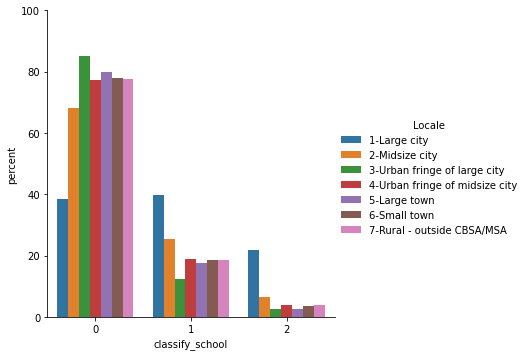

In [40]:
x, y = 'classify_school', 'Locale'
df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

Under our classification, we can see that a large proportion of schools in Large city are classified as strictly poverty stricken.

For now, we will proceed with this classification method. We can always come back and revise this and finetune our analysis.